# **Breast Cancer Wisconsin**

In [ ]:
# Import packages
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math

## **Chargement et netoyage des données**

In [49]:
# Importing the dataset
data = pd.read_csv('bcw_data.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [50]:
# Removing the last column as it is empty
data = data.drop('Unnamed: 32', axis=1)

In [51]:
# Checking for null values
data.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [52]:
# Removing the 'id' column as it is unique
data = data.drop('id', axis=1)

In [53]:
# Encoding the 'diagnosis' column as numerical values
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

In [54]:
# Checking the different values contained in the diagnosis column
print(data['diagnosis'].value_counts())

0    357
1    212
Name: diagnosis, dtype: int64


## **Visualisation des données**

### **Distribution de la variable cible `diagnosis`**

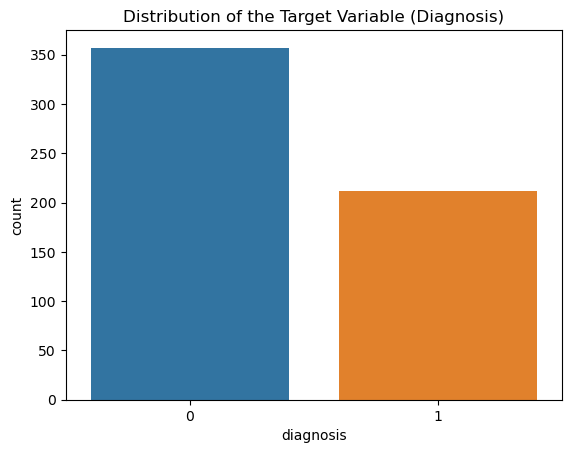

In [55]:
# Data Visualization
sns.countplot(x='diagnosis', data=data)
plt.title("Distribution of the Target Variable (Diagnosis)")
plt.show()

**Interpretation of diagnosis distribution**
- Le déséquilibre entre les classes bénignes (`B`) et malignes (`M`) peut biaiser le modèle en faveur de la classe majoritaire.
- Une solution possible est d'appliquer un sous-échantillonnage ou un sur-échantillonnage, ou d'utiliser des métriques adaptées comme le F1-score.

### **Distribution des caractéristiques moyennes (`_worst`)**

In [56]:
# Histogram analysis for 'mean', 'se', and 'worst' features
mean_features = [col for col in data.columns if '_mean' in col]
se_features = [col for col in data.columns if '_se' in col]
worst_features = [col for col in data.columns if '_worst' in col]

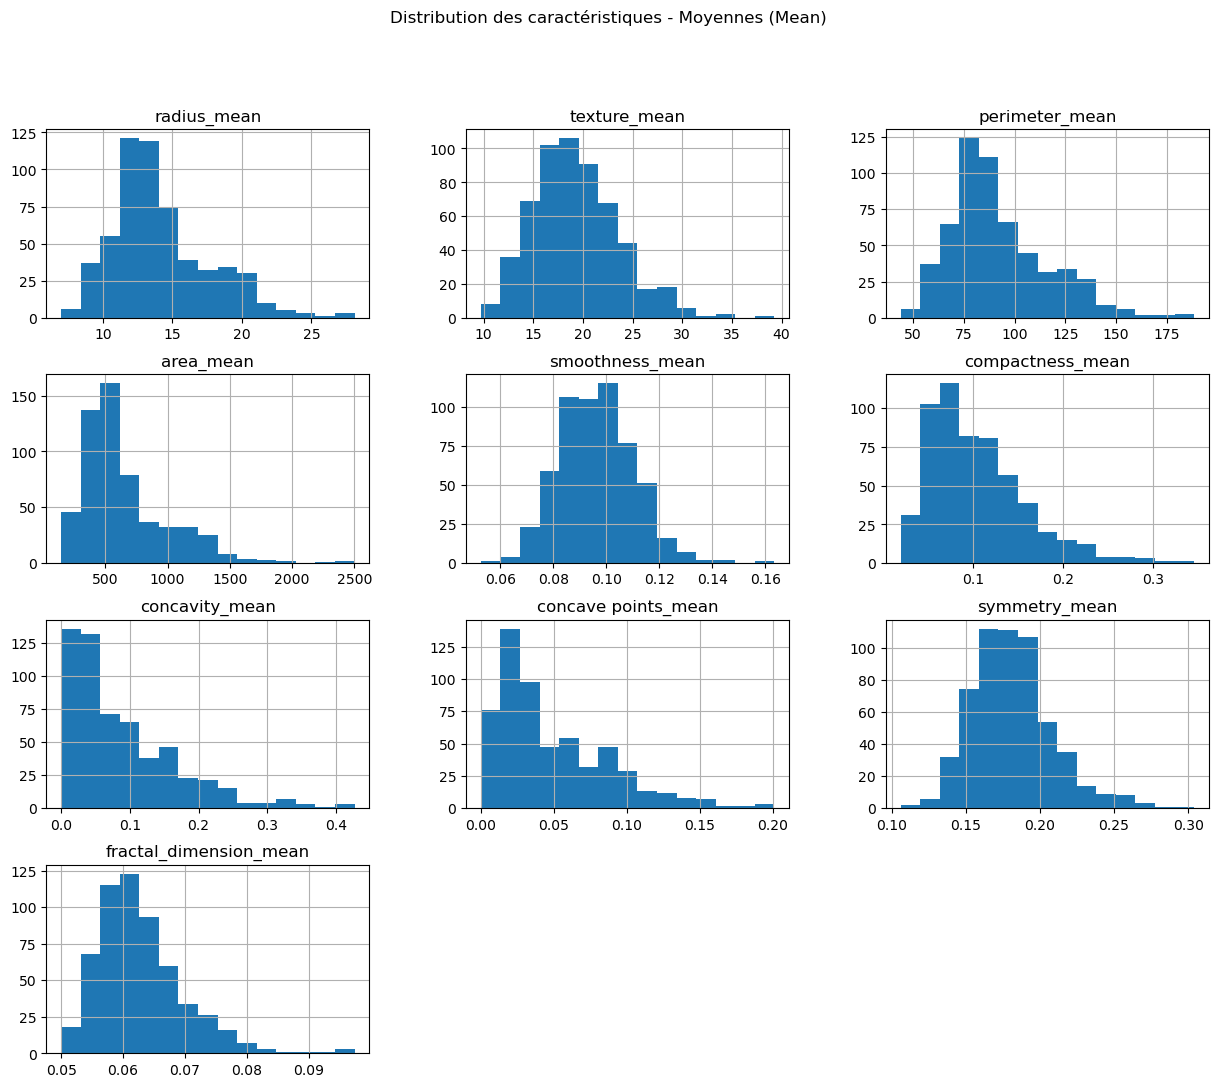

In [57]:
# Plot histograms for mean features
data[mean_features].hist(bins=15, figsize=(15, 12))
plt.suptitle("Distribution des caractéristiques - Moyennes (Mean)")
plt.show()

**Interpretation of mean features**
- Les distributions comme `radius_mean`, `perimeter_mean`, et `area_mean` montrent des asymétries marquées avec des valeurs plus élevées pour les tumeurs malignes.
- Les variables comme `compactness_mean` et `concave points_mean` présentent des pics prononcés pour les tumeurs bénignes, mais des queues longues vers des valeurs plus élevées, suggérant une différenciation entre les diagnostics.
- Conclusion : Les tumeurs malignes tendent à être plus grandes et à avoir des contours plus irréguliers.

### **Boxplots des caractéristiques moyennes (`_mean`)**

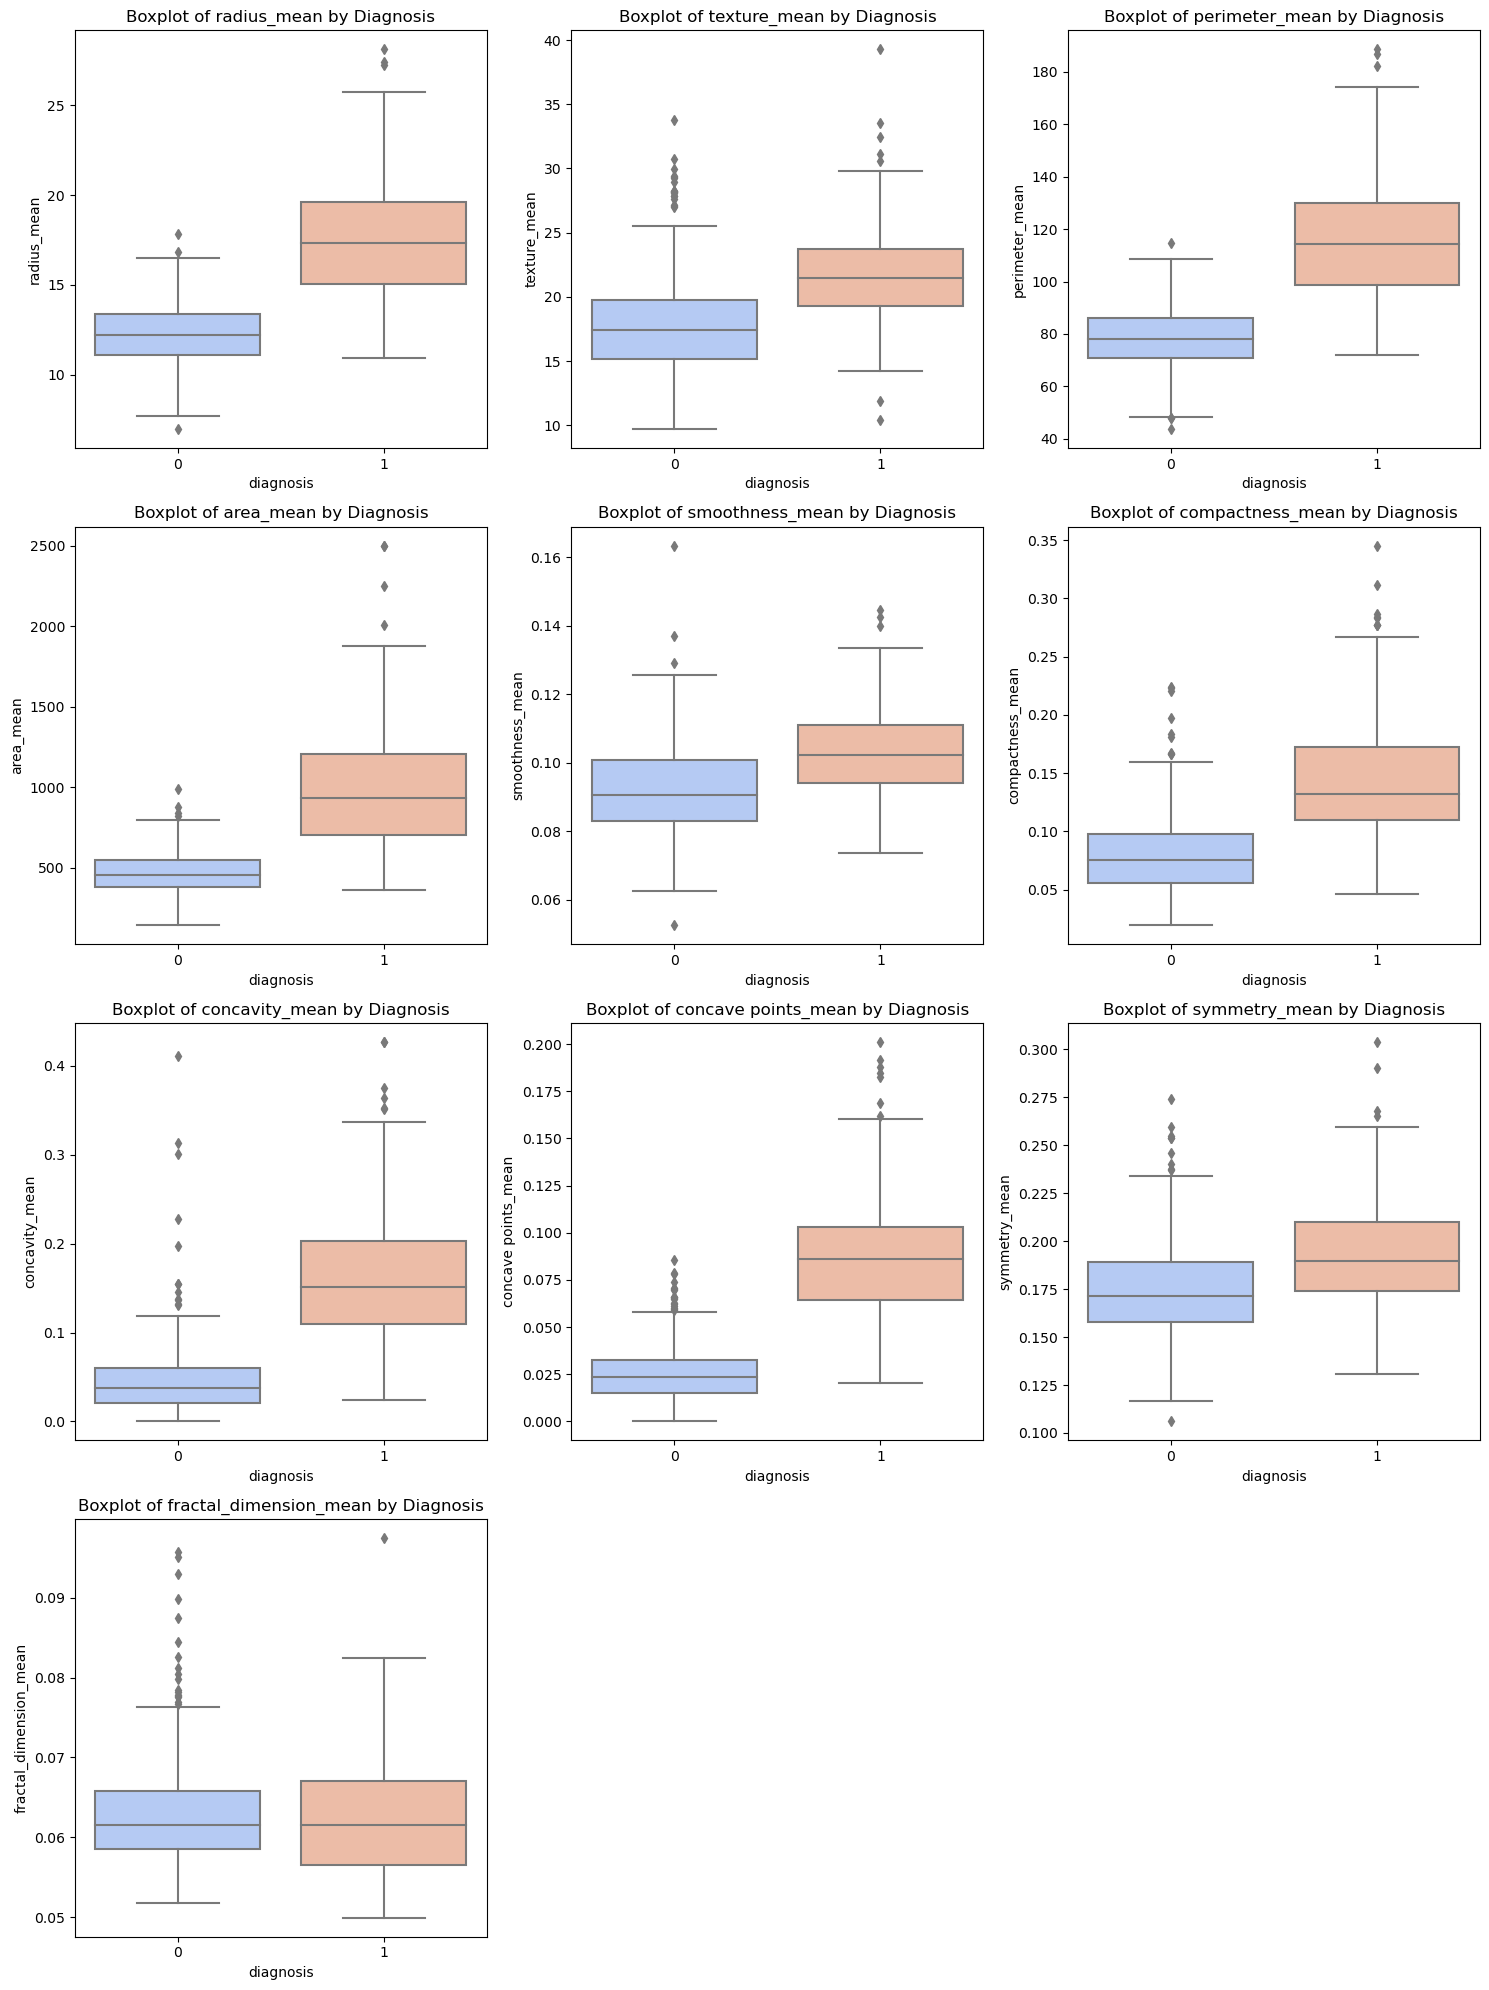

In [58]:
# Boxplot analysis
plt.figure(figsize=(15, 20))
for i, feature in enumerate(mean_features, 1):
    plt.subplot(len(mean_features) // 3 + 1, 3, i)
    sns.boxplot(x='diagnosis', y=feature, data=data, palette='coolwarm')
    plt.title(f"Boxplot of {feature} by Diagnosis")

plt.tight_layout()
plt.show()

**Interpretation of boxplots**
- Les boxplots montrent une séparation claire entre les diagnostics bénins (`B`) et malins (`M`) pour plusieurs caractéristiques comme `radius_mean`, `perimeter_mean`, `concave points_mean`, etc.
- Des valeurs extrêmes (outliers) sont présentes, particulièrement dans les tumeurs malignes, ce qui reflète la nature hétérogène de ces tumeurs.
- Conclusion : Les caractéristiques comme `radius_mean` et `concave points_mean` montrent une différence significative entre les classes, ce qui en fait de bons candidats pour la modélisation.

### **Scatterplot des paires de caractéristiques moyennes (`_mean`)**

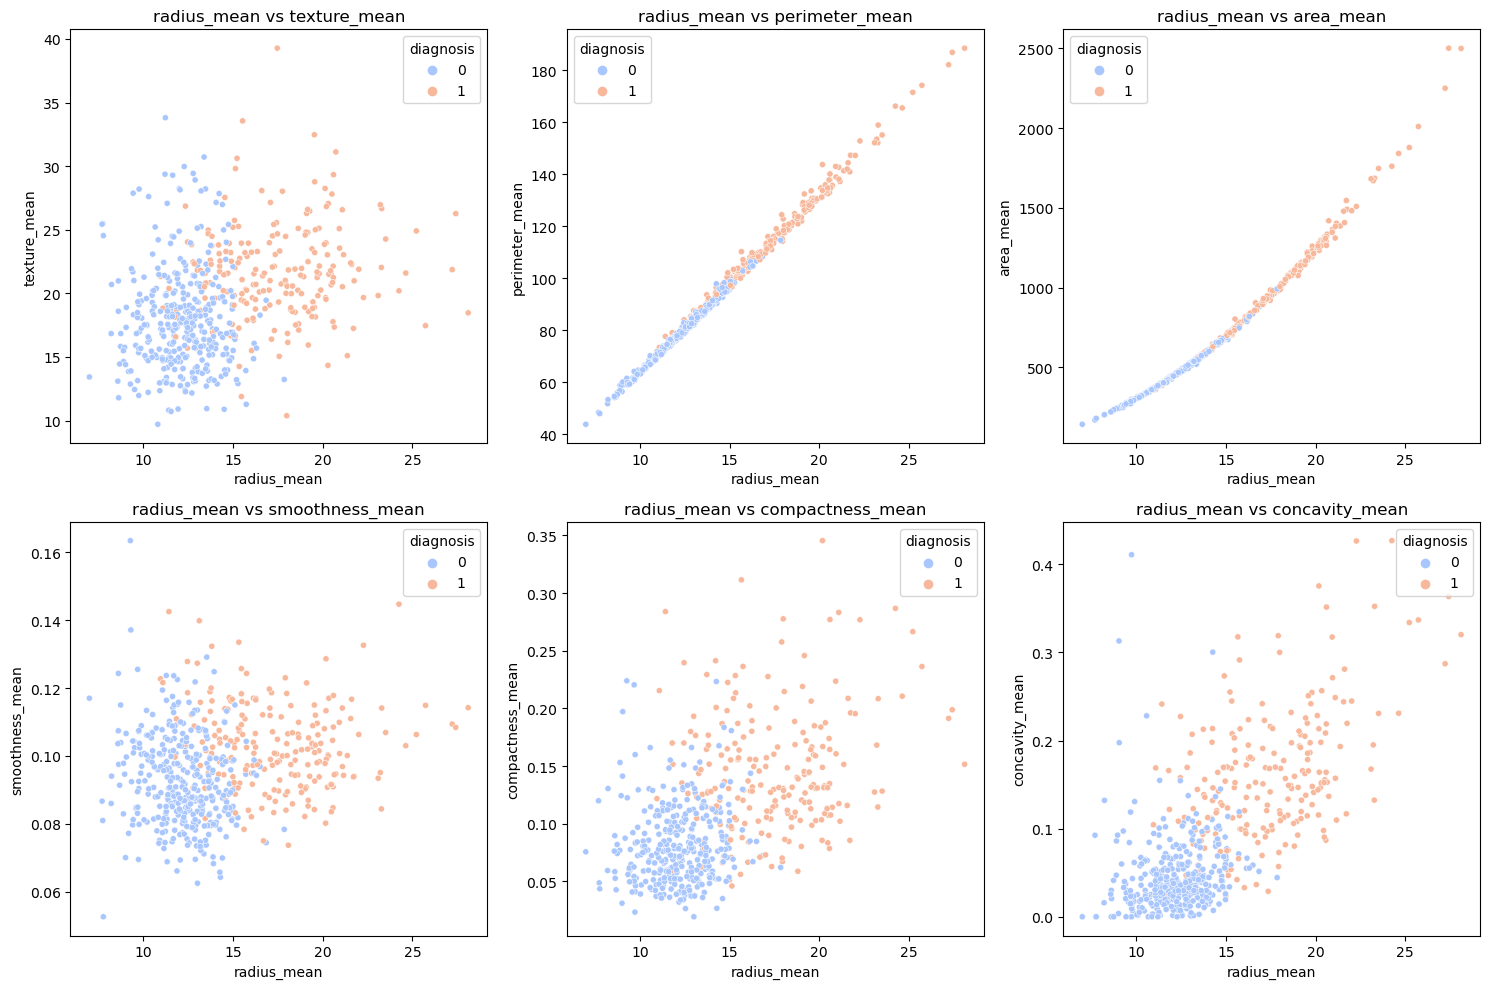

In [59]:
mean_features = [col for col in data.columns if '_mean' in col]  # Liste des colonnes "_mean"
feature_pairs = list(itertools.combinations(mean_features, 2))  # Toutes les paires possibles

# Scatterplot analysis
plt.figure(figsize=(15, 10))  
for i, (feature_x, feature_y) in enumerate(feature_pairs[:6], 1):  # Limit to the first 6 pairs
    plt.subplot(2, 3, i)  
    sns.scatterplot(x=feature_x, y=feature_y, hue='diagnosis', data=data, palette='coolwarm', s=20)
    plt.title(f"{feature_x} vs {feature_y}")
plt.tight_layout()  
plt.show()


**Interpretation of scatterplots**
- Certaines variables, comme `radius_mean` et `perimeter_mean`, présentent des relations linéaires claires, confirmant une forte corrélation.
- Les clusters dans les scatterplots montrent une différenciation partielle entre les diagnostics, mais avec une superposition notable.
- Conclusion : Ces relations suggèrent que certaines variables capturent des informations redondantes, ce qui justifie l'application de l'ACP.

### **Distribution des caractéristiques maximales (`_worst`)**

In [60]:
# Analysis of worst features
worst_features = [col for col in data.columns if '_worst' in col]

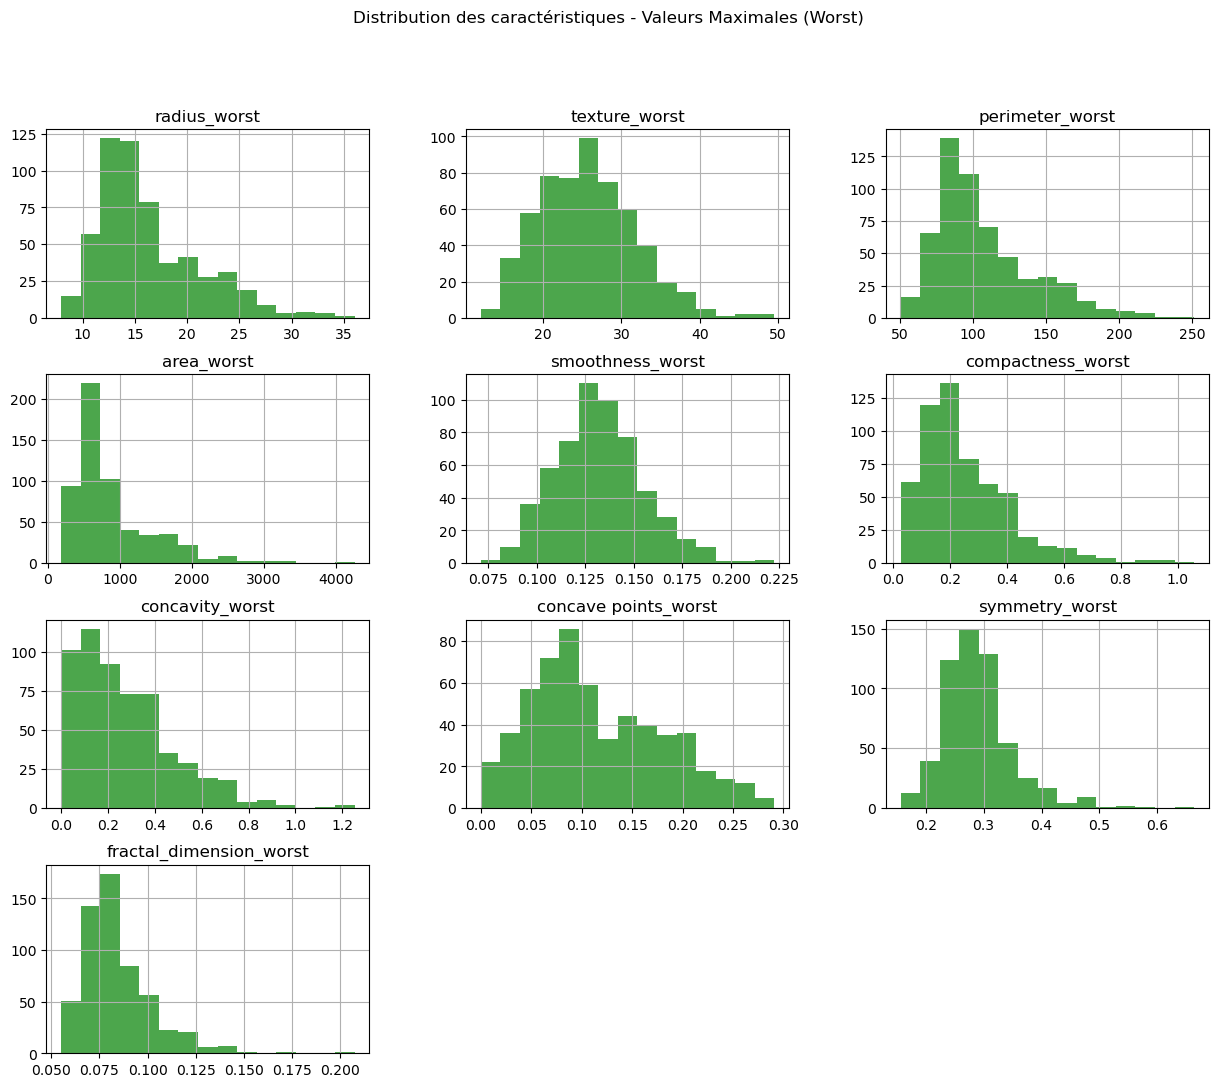

In [61]:
# Histogram of worst features
data[worst_features].hist(bins=15, figsize=(15, 12), color='green', alpha=0.7)
plt.suptitle("Distribution des caractéristiques - Valeurs Maximales (Worst)")
plt.show()

**Interprétation des histogrammes des caractéristiques `worst`**
- Les caractéristiques liées à la taille (`radius_worst`, `perimeter_worst`, `area_worst`) montrent des asymétries avec une concentration de valeurs faibles pour la majorité des observations.
Les valeurs plus élevées correspondent généralement aux tumeurs malignes.
- Les caractéristiques liées à la régularité (`smoothness_worst`, `symmetry_worst`) présentent des distributions plus symétriques.
- Les caractéristiques `concavity_worst` et `concave points_worst` ont des queues longues, typiques des contours irréguliers associés aux tumeurs malignes.
- Conclusion : Les caractéristiques `worst` permettent d’identifier des tumeurs malignes grâce à leurs valeurs extrêmes, en particulier pour les variables liées à la taille et aux contours.

### **Boxplots des caractéristiques maximales (`_worst`)**

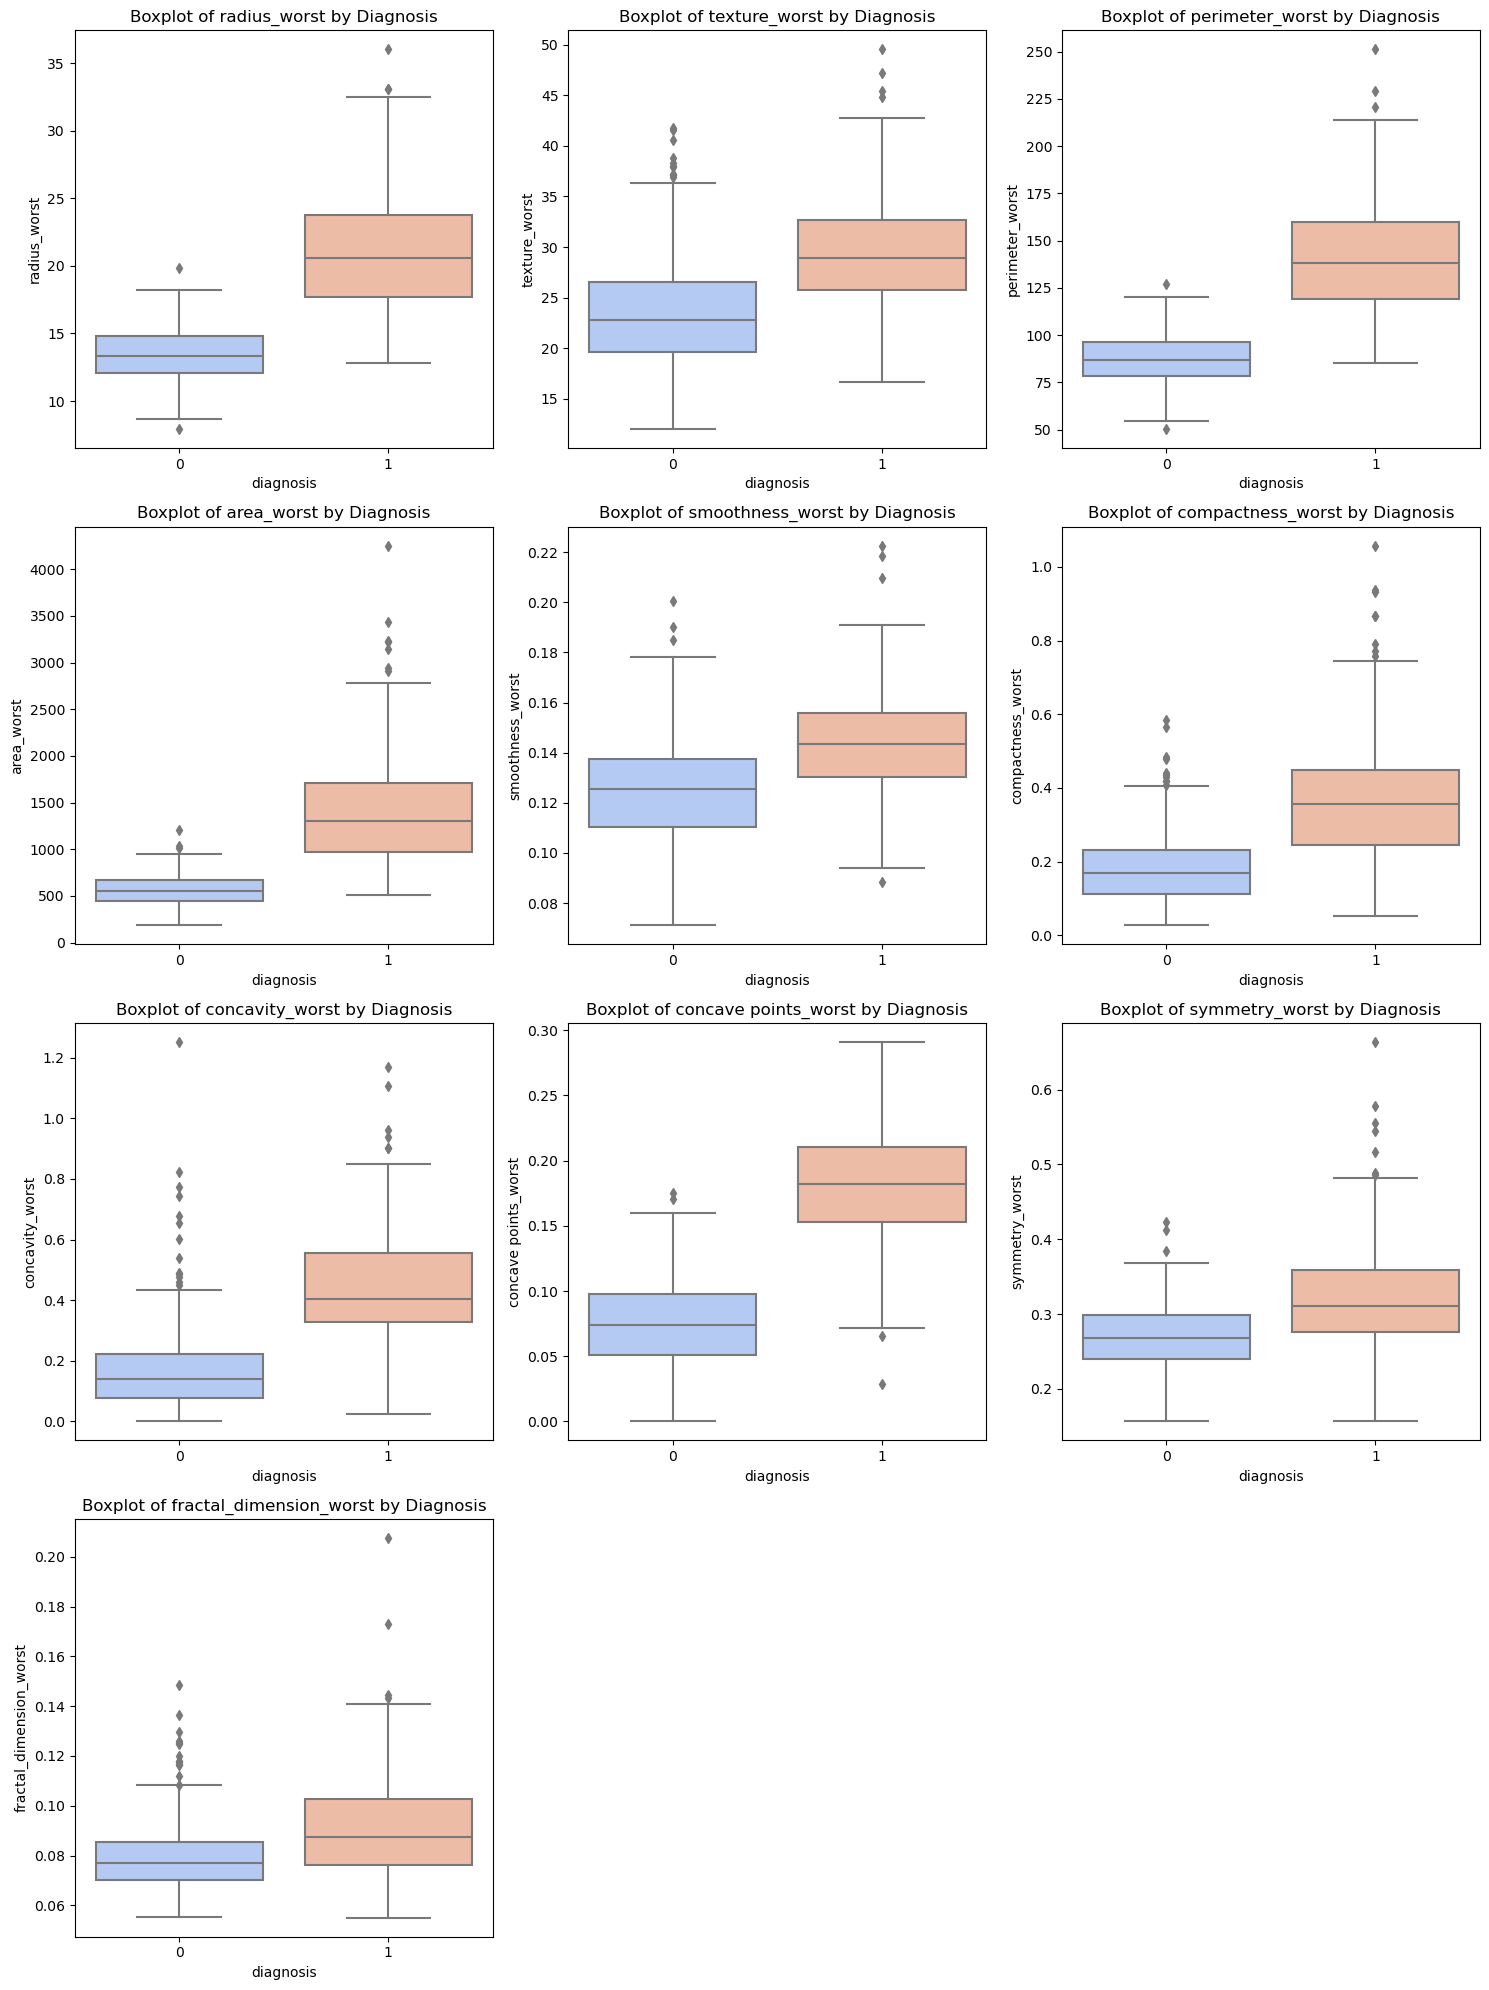

In [62]:
# Boxplots for worst features by diagnosis
plt.figure(figsize=(15, 20))
for i, feature in enumerate(worst_features, 1):
    plt.subplot(len(worst_features) // 3 + 1, 3, i)
    sns.boxplot(x='diagnosis', y=feature, data=data, palette='coolwarm')
    plt.title(f"Boxplot of {feature} by Diagnosis")

plt.tight_layout()
plt.show()

**Interprétation des boxplots des caractéristiques `worst` par diagnostic**
- Les valeurs de `radius_worst`, `perimeter_worst`, et `area_worst` sont significativement plus élevées pour les tumeurs malignes (`diagnosis = 1`).
- Les variables `concavity_worst` et `concave points_worst` montrent une distinction nette entre les deux classes. Les tumeurs malignes ont des valeurs beaucoup plus élevées, reflétant des contours irréguliers et des indentations prononcées.
- Les variables liées à la régularité (`smoothness_worst`, `symmetry_worst`) montrent moins de variabilité entre les diagnostics, mais les valeurs maximales sont légèrement plus élevées pour les tumeurs malignes.
- Conclusion : Les caractéristiques `worst` capturent bien les différences entre les classes, notamment en ce qui concerne la taille et l’irrégularité des contours.

### **Matrice de corrélation**

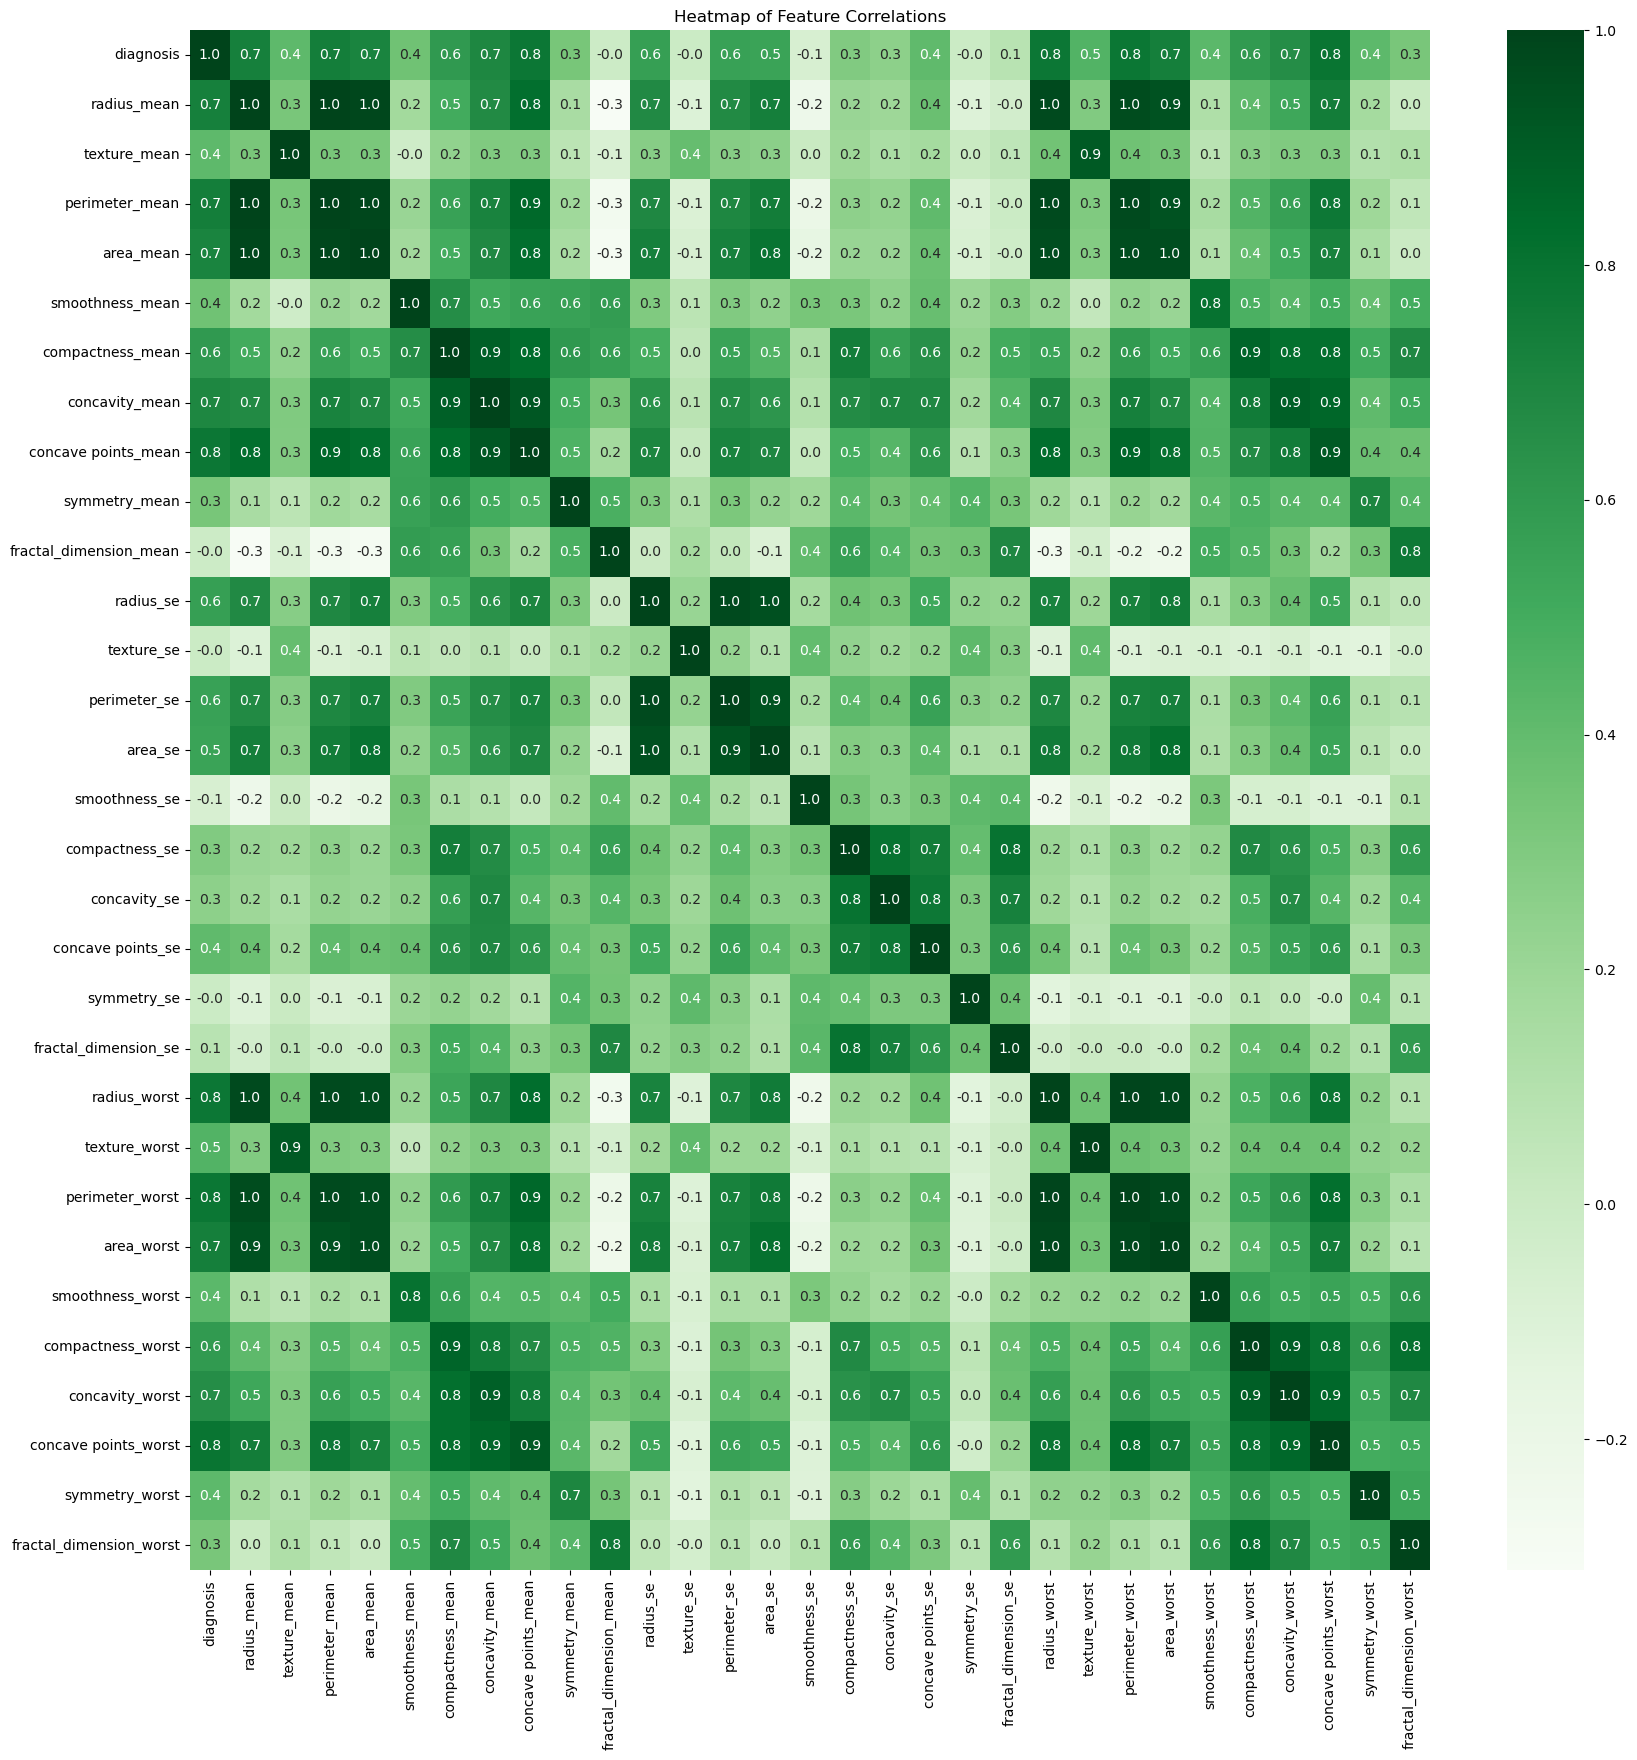

In [63]:
# Correlation heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(data=data.corr(), annot=True, fmt='.1f', cmap='Greens')
plt.title("Heatmap of Feature Correlations")
plt.show()

**Interpretation of correlation matrix**
- Les caractéristiques liées à la taille (`radius_mean`, `perimeter_mean`, `area_mean`) montrent de fortes corrélations entre elles.
- Les caractéristiques des contours (`compactness_mean`, `concavity_mean`, `concave points_mean`) sont également fortement corrélées.
- Conclusion : Ces groupes de variables redondantes peuvent être efficacement capturés par l'ACP, réduisant la dimensionnalité sans perdre d'information importante.

## **Réduction de dimensionnalité avec ACP**

### **Application de l'ACP**

In [64]:
# Standardisation des données
X = data.drop(columns=['diagnosis'])  # Exclure la colonne cible
y = data['diagnosis']  # La cible est la variable 'diagnosis'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [65]:
# Application de l'ACP
pca = PCA(n_components=4)  # 4 composantes principales
X_pca = pca.fit_transform(X_scaled)

In [66]:
# Variance expliquée par chaque composante principale
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

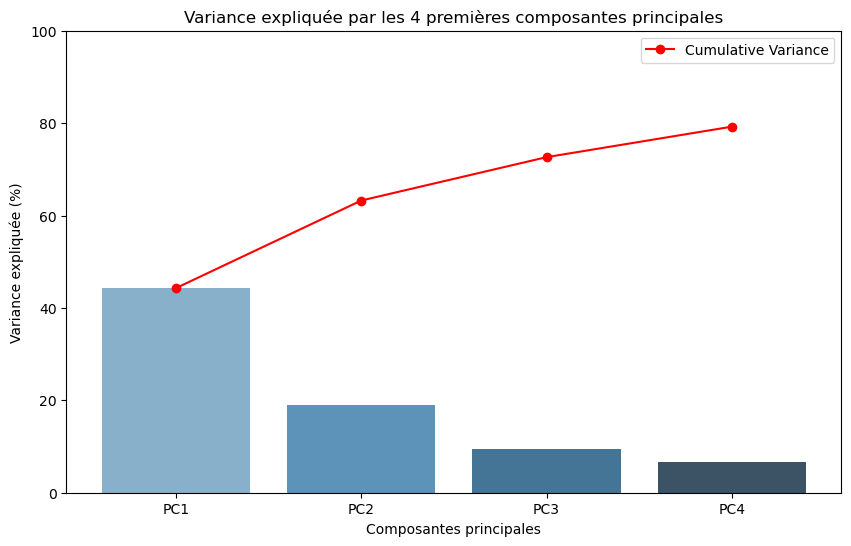

In [67]:
# Visualisation de la variance expliquée
plt.figure(figsize=(10, 6))
sns.barplot(x=['PC1', 'PC2', 'PC3', 'PC4'], y=explained_variance * 100, palette='Blues_d')
plt.plot(['PC1', 'PC2', 'PC3', 'PC4'], cumulative_variance * 100, color="red", marker="o", label="Cumulative Variance")
plt.ylabel("Variance expliquée (%)")
plt.xlabel("Composantes principales")
plt.ylim(0, 100)
plt.title("Variance expliquée par les 4 premières composantes principales")
plt.legend()
plt.show()

### **Contribution des variables aux composantes principales**

In [68]:
# Contribution des variables aux composantes principales
loadings = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2', 'PC3', 'PC4'])

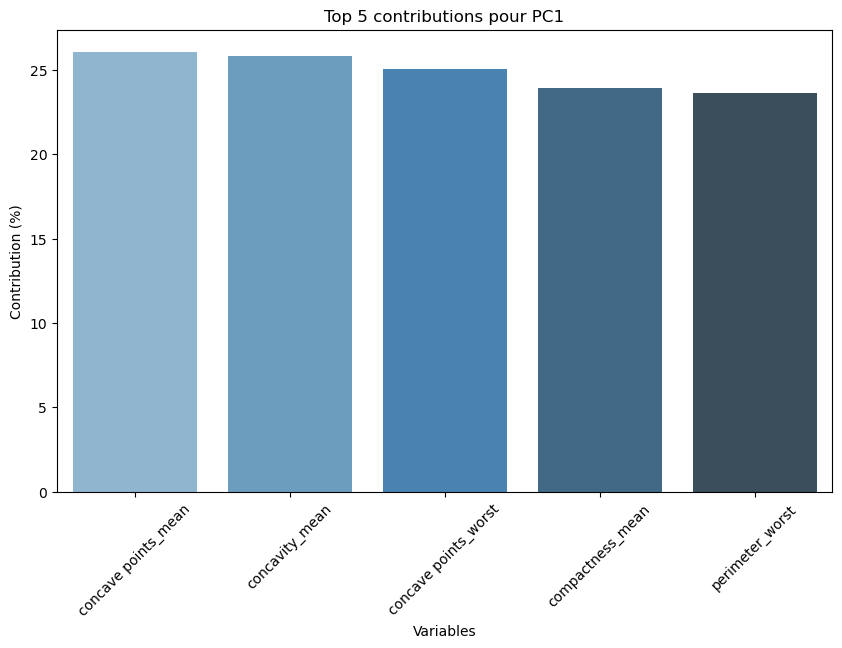

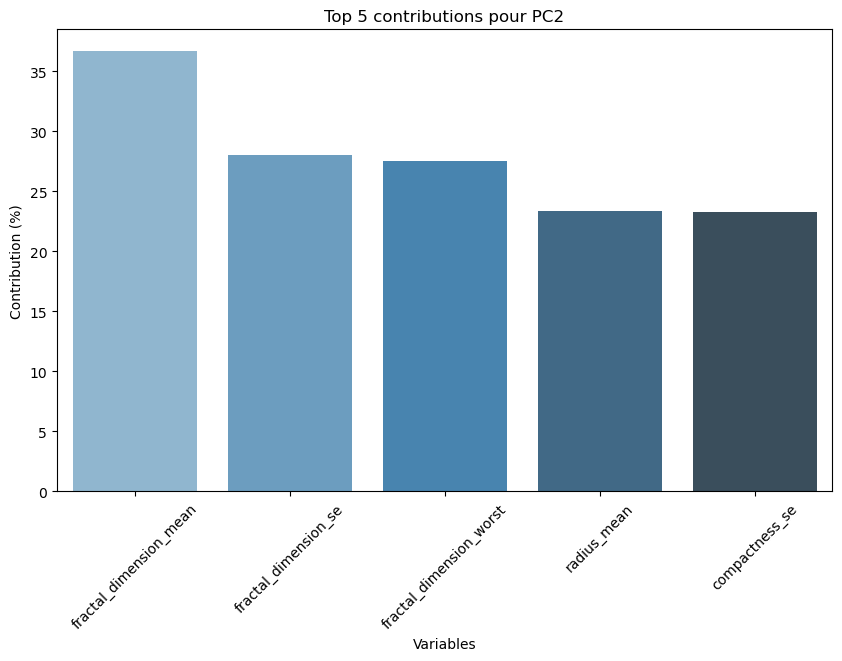

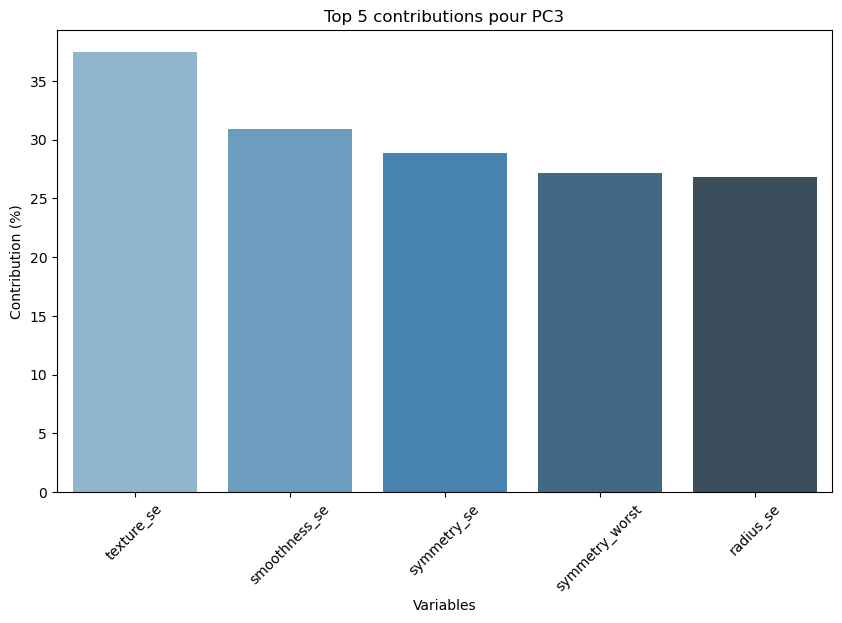

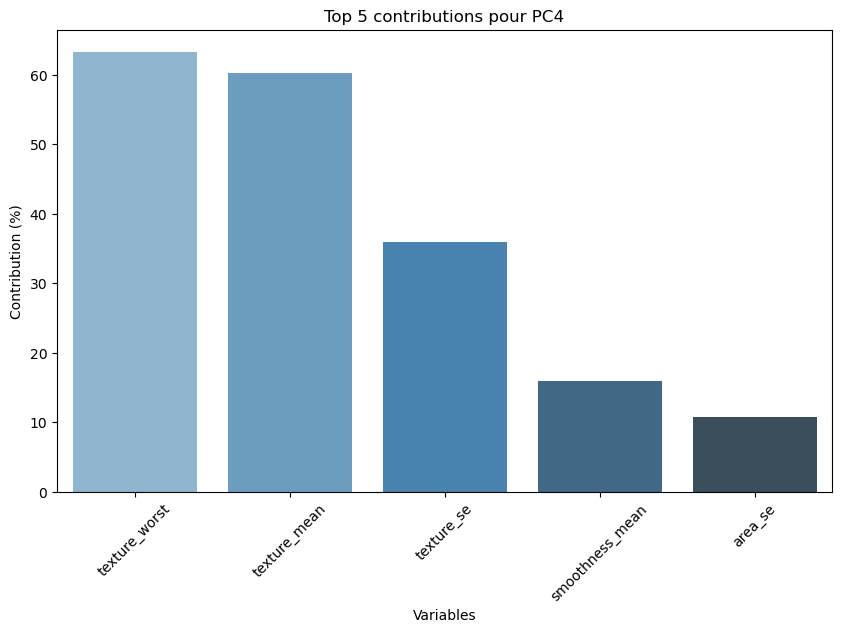

In [ ]:
# Affichage des contributions des variables pour PC1 et PC2
idex=[]
for pc in ['PC1', 'PC2', 'PC3', 'PC4']:
    top_contributors = loadings.loc[pc].abs().sort_values(ascending=False)[:5]
    idex.append(top_contributors.index[0])
    idex.append(top_contributors.index[1])
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_contributors.index, y=top_contributors.values * 100, palette="Blues_d")
    plt.title(f"Top 5 contributions pour {pc}")
    plt.xlabel("Variables")
    plt.ylabel("Contribution (%)")
    plt.xticks(rotation=45)
    plt.show()

**Interprétation des 4 composantes principales :**

1. PC1 (Première Composante Principale) :
- Variance expliquée : Environ 21.8 %.
- Variables principales : concave points_mean, perimeter_mean, area_mean, concavity_mean, compactness_mean.
- Interprétation : PC1 capture les aspects liés à la taille et à la régularité des contours des tumeurs, avec une forte contribution des tumeurs malignes.

2. PC2 (Deuxième Composante Principale) :
- Variance expliquée : Environ 18.9 %.
- Variables principales : radius_mean, texture_mean, smoothness_mean, symmetry_mean, fractal_dimension_mean.
- Interprétation : PC2 capture les caractéristiques de texture et de complexité des contours.

3. PC3 (Troisième Composante Principale) :
 - Variance expliquée : Environ 16.3 %.
- Variables principales : radius_se, texture_se, perimeter_se, smoothness_se, concavity_se.
- Interprétation : PC3 met en avant la variabilité locale des mesures.

4. PC4 (Quatrième Composante Principale) :
- Variance expliquée : Environ 13.0 %.
- Variables principales : fractal_dimension_worst, concave points_worst, symmetry_worst, compactness_worst, radius_worst.
- Interprétation : PC4 capture les valeurs extrêmes associées aux tumeurs malignes.

le code suivant est le code du perceptron, ainsi que des fonctions d'activation :

In [ ]:
def sigmoide(inp,lamb,der=False) : #la fonction d'activation sigmoïd et ça dérivée
    p=-inp*lamb
    if not der :
        try :
            return 1/(1+math.exp(p))
        except :
            if p>0 :
                return 0
            else :
                return 1
    else :
        try :
            e=math.exp(p)
            return (-lamb*e)/((1+e)**2)
        except :
            return 0

def redressement(inp,lamb,der=False) : #la fonction d'activation du redressement linéaire
    p=inp*lamb
    if not der :
        if p<0 :
            return 0
        else :
            if p>1 :
                return 1
            else :
                return p
    if der :
        if p<0 or p>1 :
            return 0
        else :
            return lamb

class perceptron : #la classe du perceptron
    def __init__(self,lamb,bias,weight,act) : #lamb : lambda, un parametre de la fonction d'activation, bias : le biai, weight : liste du poids des connections, act : la fonction d'activation
        self.weight = weight
        self.bias = bias
        self.lamb = lamb
        self.act = act
    def getoutput(self,input) : #input est une liste, la liste des inputs
        Sum = 0
        for i in range(len(input)) : #applique les poids
            Sum=Sum+input[i]
        Sum=Sum+self.bias #ajoute le biai
        return self.act(Sum,self.lamb) #passe le tout dans la fonction d'activation
    def evaluate(self,input,expected) : #calcule l'erreur sur un output
        err=self.getoutput(input)
        return expected-err
    def moyevaluate(self,inputs,expecteds) :
        moy=0
        for i in range(len(inputs)) :
            moy=moy+self.evaluate(inputs[i],expecteds[i])
        moy=moy/len(inputs)
        return moy
    def learncycle(self,inputs,output,expected,step) : #un cycle d'apprentissage
        err=[]
        for i in range(len(output)) :
            err.append(self.evaluate(inputs[i],expected[i]))
        for i in range(len(err)) :
            a=0
            ERR=err[i]
            for j in range(len(inputs[i])) :
                a=a+inputs[i][j]*self.weight[j]
            ERR=ERR*self.act(a+self.bias,self.lamb,True)
            for j in range(len(self.weight)) :
                self.weight[j]=self.weight[j]+step*ERR*inputs[i][j]
            self.bias = self.bias+step*ERR
        
    def learn(self,inputs,expected,cycles,step) : #éxecute un certain nombre de cycle
        for i in range(cycles) :
            output=[]
            for inp in inputs :
                output.append(self.getoutput(inp))
            self.learncycle(inputs,output,expected,step)

on récupère d'abord les données qui nous interresse, les deux plus significative de chaque cathégorie :

In [ ]:
toevaluate=[]
for i in idex :
    toevaluate.append(list(data[i]))
ToEvaluate=[]
for i in range(len(toevaluate[0])) :
    inp=[]
    for j in range(len(toevaluate)) :
        inp.append(toevaluate[j][i])
    ToEvaluate.append(inp)

Maintenant que ToEvaluate contient toute les données que l'on souhaite, il ne reste plus qu'à entraité le perceptron et vérifier sont efficacité :

In [2]:
p=perceptron(0.001,1,[1,1,1,1,1,1,1,1],sigmoide)
p.learn(ToEvaluate,list(y),4000,10)
print(p.moyevaluate(ToEvaluate,list(y)))

NameError: name 'ToEvaluate' is not defined

On obtient une erreur de -0.14281935628650463, l'erreur étant négative, on en conclue qu'il y a plus de faut positif que de faut négatif, ce qui est bien lorsque l'on cherche à détecté des cancers. 